# NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise I have whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. I will show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 1: Read and analyze the data

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head() # check the first few rows

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


"fare_amount" is the column we'll predict. Let's check the distribution of this column in our dataset.

In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

We see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

# STEP 2: Go through the feature engineering

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat_1, long_1, lat_2, long_2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    earth_r = 6371  # average radius of Earth in kilometers
       
    phi_1 = np.radians(df[lat_1])
    phi_2 = np.radians(df[lat_2])
    
    delta_phi = np.radians(df[lat_2]-df[lat_1])
    delta_lambda = np.radians(df[long_2]-df[long_1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    k_distance = (earth_r * c) # in kilometers
    m_distance = k_distance * 0.621371 # in miles

    return m_distance

In [5]:
df['dist_miles'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.321228
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,0.865139
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2.067154
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.158316
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4.493333


Let's check the distribution of our newly created column

In [6]:
df['dist_miles'].describe()

count    120000.000000
mean          2.064294
std           2.073518
min           0.006343
25%           0.817990
50%           1.390059
75%           2.506961
max          17.924295
Name: dist_miles, dtype: float64

## Add a datetime column and derive useful data
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [7]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.321228,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,0.865139,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2.067154,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.158316,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4.493333,2010-04-16 22:19:01,22,pm,Fri


## Separate categorical columns from continuous columns

In [8]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_miles', 'EDTdate', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')

In [9]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']

In [10]:
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_miles']

# we entered the continuous columns explicitly because there are columns we're not running through the model 
# (pickup_datetime and EDTdate)

In [11]:
y_col = ['fare_amount']  # this column contains the labels, the values we are predicting

<div class="alert alert-info"><strong>NOTE:</strong> If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [12]:
# Convert our three categorical columns ['Hour', 'AMorPM', 'Weekday'] to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [13]:
# lets print and check all the data types in data frame
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_miles                  float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [14]:
# lets check some df['Hour'] values
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values also correspond to the codes assigned to each name.

In [15]:
# lets check some df['AMorPM'] values
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [16]:
# lets check some df['Weekday'] values
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

We can access the category names with Series.cat.categories or just the codes with Series.cat.codes. This makes more sense when we look at df['AMorPM'] or others

In [17]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [18]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [19]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using numpy.stack We don't want the Series index, just the values.

In [20]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

# all of the above can also be done in one line (more pythonic way)
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

cats.shape

(120000, 3)

In [21]:
# prints only 5 rows
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

# Convert numpy arrays to tensors

To perform Machine Learning related work, we need to convert our data into tensors. We start with numpy and then to tensors.

In [22]:
# Convert categorical variables to a tensors
cats = torch.tensor(cats, dtype=torch.int64)

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [23]:
# Convert continuous variables to numpy and then to tensors
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   1.3212],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   0.8651],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   2.0672],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.1583],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   4.4933]])

In [24]:
conts.type()

'torch.FloatTensor'

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y / labels (the value we are predicting)</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [25]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [26]:
cats.shape

torch.Size([120000, 3])

In [27]:
conts.shape

torch.Size([120000, 6])

In [28]:
y.shape

torch.Size([120000, 1])

## Embeddings for Categorical Variables

A key technique to making the most of deep learning for tabular data is to use embeddings for your categorical variables. This approach allows for relationships between categories to be captured. Perhaps Saturday and Sunday have similar behavior, and maybe Friday behaves like an average of a weekend and a weekday. Similarly, for zip codes, there may be patterns for zip codes that are geographically near each other, and for zip codes that are of similar socio-economic status.

Source: https://www.fast.ai/2018/04/29/categorical-embeddings/

Here is the path you have to go through for category embedding.

![title](images/category-embedding.png)
Image Source: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [29]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

Before we code the TabularModel, here is the picture again

![title](images/category-embedding.png)
Image Source: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

In [30]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        ## emb_szs: list of tuples: each categorical variable size is paired with an embedding size
        ## n_cont: int: number of continuous variables
        ## out_sz: int: output size
        ## layers: list of ints: layer sizes
        ## p: float: dropout probability for each layer (for simplicity we'll use the same value throughout)
                                              
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [31]:
model = TabularModel(emb_szs, conts.shape[1], 1, [1000,500], p=0.4)

In [32]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

## Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

Here are the various Loss functions:

Regression Loss Functions
* Mean Squared Error Loss
* Mean Squared Logarithmic Error Loss
* Mean Absolute Error Loss

Binary Classification Loss Functions
* Binary Cross-Entropy
* Hinge Loss
* Squared Hinge Loss

Multi-Class Classification Loss Functions
* Multi-Class Cross-Entropy Loss
* Sparse Multiclass Cross-Entropy Loss
* Kullback Leibler Divergence Loss

In [33]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
batch_size = 10000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [35]:
len(cat_train)

8000

In [36]:
len(cat_test)

2000

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

In [37]:
import time
start_time = time.time()

epochs = 400
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.41653824
epoch:  26  loss: 10.21514034
epoch:  51  loss: 9.69560623
epoch:  76  loss: 8.39893055
epoch: 101  loss: 5.76374674
epoch: 126  loss: 3.72212243
epoch: 151  loss: 3.72262764
epoch: 176  loss: 3.53131747
epoch: 201  loss: 3.44463754
epoch: 226  loss: 3.42164469
epoch: 251  loss: 3.29469633
epoch: 276  loss: 3.27677751
epoch: 301  loss: 3.23937273
epoch: 326  loss: 3.18705082
epoch: 351  loss: 3.15754247
epoch: 376  loss: 3.13695574
epoch: 400  loss: 3.08489323

Duration: 459 seconds


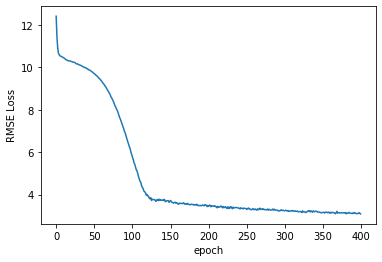

In [38]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [39]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.52004981


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [40]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   6.2244   4.5000   1.7244
 2.   7.5593   7.3000   0.2593
 3.   6.7583   6.1000   0.6583
 4.   7.6676   8.5000   0.8324
 5.   4.2858   3.7000   0.5858
 6.   9.1208  11.3000   2.1792
 7.   8.4581   6.9000   1.5581
 8.  11.0709  11.7000   0.6291
 9.   7.1542   6.5000   0.6542
10.   8.0238   7.3000   0.7238
11.   9.4850  10.9000   1.4150
12.   4.3692   6.5000   2.1308
13.   9.9410  10.5000   0.5590
14.   8.5321  12.1000   3.5679
15.   8.3157   8.1000   0.2157
16.   5.4487   4.9000   0.5487
17.  19.6535  16.9000   2.7535
18.   8.0682  13.3000   5.2318
19.  18.7062  27.6000   8.8938
20.   7.8935   5.7000   2.1935
21.  11.4199  15.7000   4.2801
22.   5.2447   4.5000   0.7447
23.   4.7439   5.3000   0.5561
24.   5.6191   5.7000   0.0809
25.   4.6106   4.9000   0.2894
26.  14.7308  12.9000   1.8308
27.   6.2036  16.9000  10.6964
28.   6.9158   6.5000   0.4158
29.   5.2465   5.3000   0.0535
30.   9.9661   8.1000   1.8661
31.   6.8984   7.3000   0.4016
32.   5.

So while many predictions were off by a few cents, some were off by \\$11.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

## Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [41]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [42]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat_1, long_1, lat_2, long_2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    earth_r = 6371  # average radius of Earth in kilometers
       
    phi_1 = np.radians(df[lat_1])
    phi_2 = np.radians(df[lat_2])
    
    delta_phi = np.radians(df[lat_2]-df[lat_1])
    delta_lambda = np.radians(df[long_2]-df[long_1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    k_distance = (earth_r * c) # in kilometers
    m_distance = k_distance * 0.621371 # in miles

    return m_distance

class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [43]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [1000,500], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [45]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [46]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

## Feed new data through the trained model
For convenience, here are the max and min values for each of the variables:
<table style="display: inline-block">
<tr><th>Column</th><th>Minimum</th><th>Maximum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>Use caution!</strong> The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [47]:
z = test_data(model2)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.9
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare amount is $10.83
